## Titanic Data Mining Example TR
--------------------------------------------------------------------
Merhaba Titanic verisi için basit bir veri işleme ve nöral ağ kurmaya çalıştım.
Sonuç olarak %80 civarında kötü bir başarı yakaladım.Bunun sebebi bu kadar az bir veriyle bir nöral ağ kurmak muhtemelen sorunun temel kaynağı burdaki sorunu nöral ağlar dışında başka bir sınıflandırma methoduyla çözmek daha iyi sonuçlar verebilir.

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


Öncelikle egitim ve test verilerimizi dosyalardan çekiyoruz.

In [2]:
train_data = pd.read_csv('../titanic/train.csv', header = 0)
test_data = pd.read_csv('../titanic/test.csv', header = 0)

Çektiğimiz verilere göz atalım.

In [3]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Peki hangi öznitelikler bizim için önemli? Hangilerini önemsiz ve drop edilmeli bunu anlamak için grafikleri kullanacağız. Önce kurtulan(Survived) ve ölen(Died) sayısını karşılaştıralım.

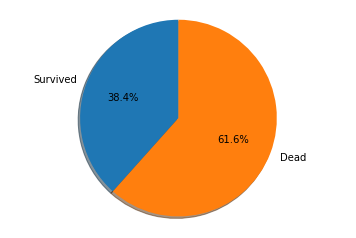

In [4]:
number_of_Survived = 0
number_of_Dead = 0
for i in train_data['Survived']:
    if i == 0:
        number_of_Dead = number_of_Dead+1
    if i == 1:
        number_of_Survived = number_of_Survived+1

labels = 'Survived','Dead'
sizes = [number_of_Survived, number_of_Dead]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

Grafiktede gördüğümüz üzere çoğunluk kurtulmayı başaramamış durumda.Tabi bu train seti için böyle.Şimdi ilk özniteliğimiz **PassengerID** ve burdaki sayıların gemiden sağ çıkmak ile herhangi bir ilgisi yok dolayısıyla drop ediyoruz yani siliyoruz.Ancak test setinin **id** listesi bize tahmin kısmında lazım olacak o yüzden onu başka bir değişkene aktaralım.

In [5]:
train_data = train_data.drop('PassengerId',axis = 1)
test_data_id_list = test_data['PassengerId']
test_data = test_data.drop('PassengerId',axis = 1)

İkinci özniteliğimiz **Survived** ancak o bizim aynı zamanda hedefimiz yani tahmn etmek istediğimiz değerleri içerdiği için şimdilik dokunmuyoruz.

Ardından **Pclass** geliyor ve bize yolcuların bilet sınıfını söylüyor.Yüksek sınıf yolcuların geminin daha üst kısımlarında bulunduğunu düşünürsek kurtulma ihtimallerinin daha fazla olduğunu göz önüne alabiliriz.Ayrıca zengin olduları için kaza anında ve sonrasında bazı avantajlar yakalamış olabilirler.Yinede emin olmak için grafik üzerinde görelim.

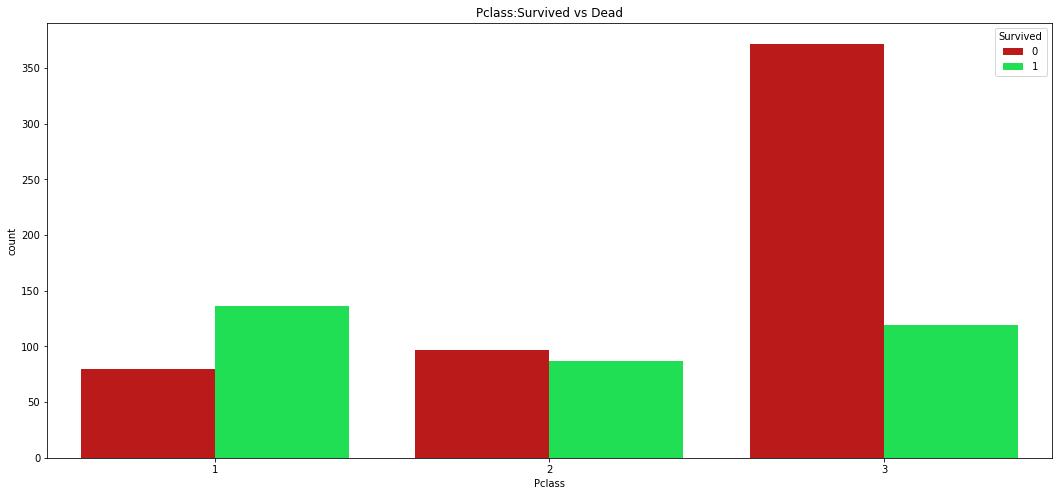

In [6]:
fig2, ax1 = plt.subplots(figsize=(18,8))
sns.countplot('Pclass', hue='Survived', data=train_data,ax=ax1, palette=['#d40000','#00ff45'])
ax1.set_title('Pclass:Survived vs Dead')
plt.show()

Açıkca görüldüğü üzere 3.sınıfların durumu çok daha kötü.Buda **Pclass**'ın bizim için çok önemli bir öznitelik olduğu anlamına geliyor.

Sırada 'name' yani isimler var ama tahmin edebileceğiniz gibi yolcu isimleri ile ölüp ölmedikleri arasında herhangi bir bağ yok yani onu iki hem train hem test veri setimizden drop ediyoruz yani siliyoruz.

In [7]:
train_data = train_data.drop('Name',axis = 1)
test_data = test_data.drop('Name',axis = 1)

Sırada 'sex' yani cinsiyet var acaba cinsiyet(sex) ile kurtulma(survive) arasında bir bağlantı var mı bakalım.

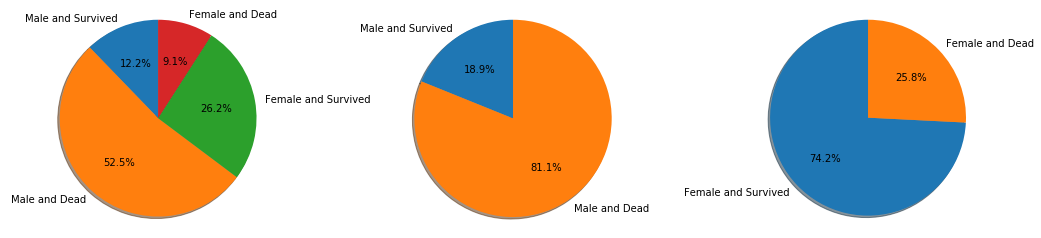

In [8]:
number_of_survived_and_male = 0
number_of_dead_and_male = 0
number_of_survived_and_female = 0
number_of_dead_and_female = 0

for i in train_data.values:
    if i[0] == 0 and i[2] == 'male':
        number_of_dead_and_male = number_of_dead_and_male+1
    if i[0] == 0 and i[2] == 'female':
        number_of_dead_and_female = number_of_dead_and_female+1
    if i[0] == 1 and i[2] == 'male':
        number_of_survived_and_male = number_of_survived_and_male+1
    if i[0] == 1 and i[2] == 'female':
        number_of_survived_and_female = number_of_survived_and_female+1

labels0 = 'Male and Survived','Male and Dead','Female and Survived','Female and Dead'
sizes0 = [number_of_survived_and_male, number_of_dead_and_male ,number_of_survived_and_female ,number_of_dead_and_female]

labels1 = 'Male and Survived','Male and Dead'
sizes1 = [number_of_survived_and_male, number_of_dead_and_male]

labels2 = 'Female and Survived','Female and Dead'
sizes2 = [number_of_survived_and_female ,number_of_dead_and_female]

fig3, ax = plt.subplots(1,3,figsize=(18,4))

ax[0].pie(sizes0, labels=labels0, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[0].axis('equal')

ax[1].pie(sizes1, labels=labels1, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[1].axis('equal')

ax[2].pie(sizes2, labels=labels2, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[2].axis('equal')

plt.show()


Görüldüğü üzere kadınların kurtulma şansı çok çok daha yüksekmiş yani cinsiyet kullanmamız gereken önemli bir öznitelik.

Sırada 'age' yani yolcuların yaşı var.Peki acaba bu önemli bir öznitelik mi grafikler ile görmeye çalışalım.Ancak ondan önce **Age** bazı **nan** yani belli olmayan değerlere sahip.Bu da yolcuların bazılarının yaşının bilinmediği anlamına geliyor.Bu şekilde devam edemyeceğimiz için bu belli olmayan değerleri başka bir değerler doldurmak zorundayız.Bunu yapmanın **Age** özniteliği için en iyi yolu bilinenlerin ortalamasını alıp bilinmeyenlere yazmak.Ancak başka yollarda mevcut.

In [9]:
train_data.loc[train_data.Age.isnull(),'Age'] = int(train_data['Age'].mean())
test_data.loc[test_data.Age.isnull(),'Age'] = int(test_data['Age'].mean())

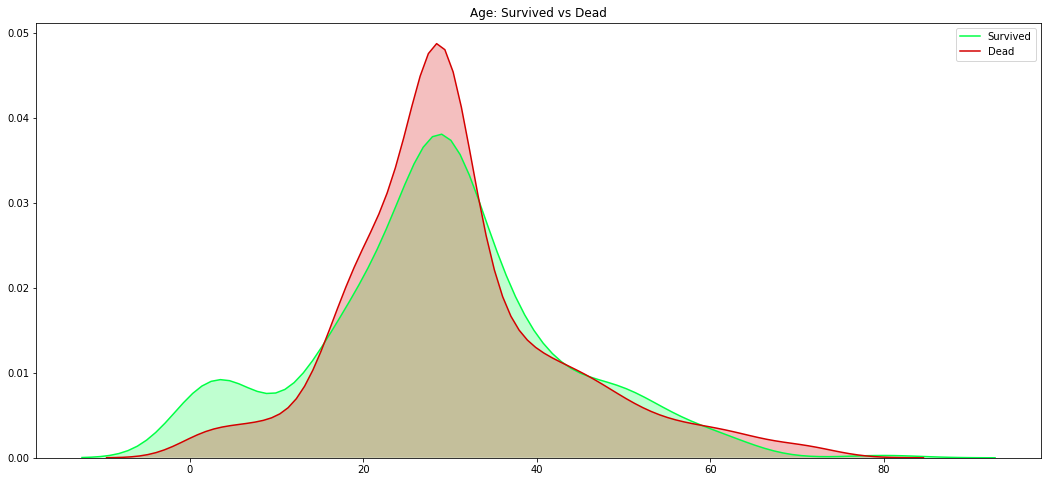

In [10]:
temp_survived_ages = pd.DataFrame()
temp_dead_ages = pd.DataFrame()
temp_dead_age_list = []
temp_survived_age_list = []
for i in train_data.values:
    if i[0] == 0:
        temp_dead_age_list.append(i[3])
    if i[0] == 1:
        temp_survived_age_list.append(i[3])
        
temp_dead_ages['Dead'] = temp_dead_age_list          
temp_survived_ages['Survived'] = temp_survived_age_list       

fig4, ax1 = plt.subplots(figsize=(18,8))
sns.kdeplot(temp_survived_ages['Survived'], color='#00ff45', shade=True)
sns.kdeplot(temp_dead_ages['Dead'], color='#d40000', shade=True)
ax1.set_title('Age: Survived vs Dead')
plt.show()

Grafikte gördüğümüz üzere 0-15 yaş aralığının kurtulma oranı daha fazla iken 20-40 yaş arasında ölüm oranı daha fazla yani yaş(age)'da bizim için önemli bir öznitelik.

Sırada SibSP var.Bu öznitelik yolcunun kemide kaç kardeşi olduğu söylüyor bize.Peki kurtulmaya bir etkisi var mı?Grafikleri ile görelim.

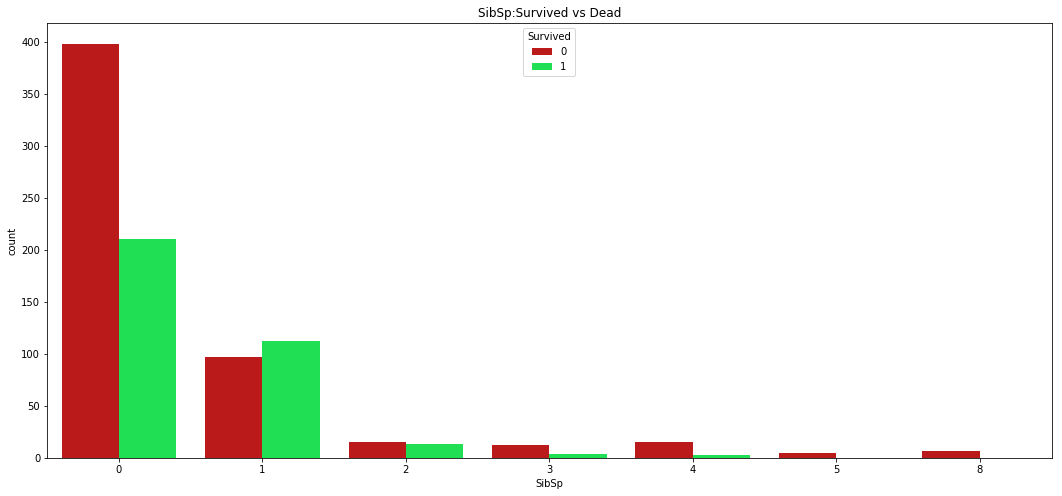

In [11]:
fig5, ax1 = plt.subplots(figsize=(18,8))
sns.countplot('SibSp', hue='Survived', data=train_data,ax=ax1, palette=['#d40000','#00ff45'])
ax1.set_title('SibSp:Survived vs Dead')
plt.show()

Grafiğe baktığımızda kardeşi olmayanların çoğu ölürken 1 kardeşi olanların kurtulma şansı biraz daha yükselmiş ancak 2 ve daha fazla kardeşi olanlarda bu durum tekrar değişiyor.Burdan çıkartığım sonuç bu özniteliğin önemsiz olmadığını o yüzden drop etmiyorum.

Geldik **Parch** yani yolcuların yanlarında getirdikleri çocuk sayısına. **SibSp** ile aynı şekilde grafiğe oturtalım.

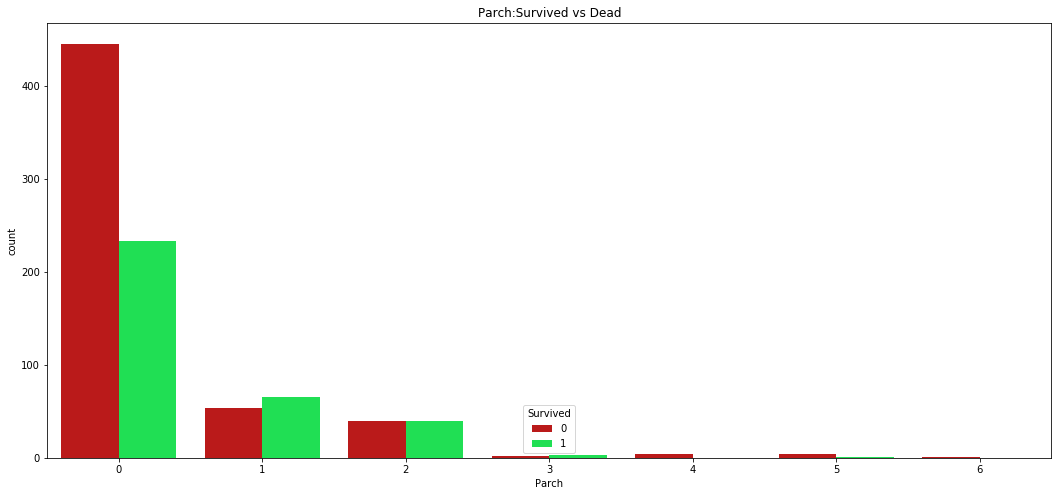

In [12]:
fig6, ax1 = plt.subplots(figsize=(18,8))
sns.countplot('Parch', hue='Survived', data=train_data,ax=ax1, palette=['#d40000','#00ff45'])
ax1.set_title('Parch:Survived vs Dead')
plt.show()

Grafikte görüldüğü üzere çocucğu olan insanların gemiden ayrılırken bir öncelik hakkında sahip olduğu açık bir şekilde belli oluyor.Bu da **Parch**'ın önemli bir öznitelik olduğunu gösteriyor.

**Ticket** özniteliğine geldik.Bu özniteliği listede incelediğimizde harf ve sayılarla karışık tahminen **random** atanmış sayılar olduğuna kanaat getiriyorum. Dolayısıyla öznitelik olarak kullanıyorum.

In [13]:
train_data['Ticket']

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
5                330877
6                 17463
7                349909
8                347742
9                237736
10              PP 9549
11               113783
12            A/5. 2151
13               347082
14               350406
15               248706
16               382652
17               244373
18               345763
19                 2649
20               239865
21               248698
22               330923
23               113788
24               349909
25               347077
26                 2631
27                19950
28               330959
29               349216
             ...       
861               28134
862               17466
863            CA. 2343
864              233866
865              236852
866       SC/PARIS 2149
867            PC 17590
868              345777
869              347742
870              349248
871             

In [14]:
train_data = train_data.drop('Ticket',axis = 1)
test_data = test_data.drop('Ticket',axis = 1)

Sırada **Fare** yani bilet ücreti özniteliği var.Kurtulma durumuna bir etkisi olup olmadığını görmek için grafiğe koyalım.

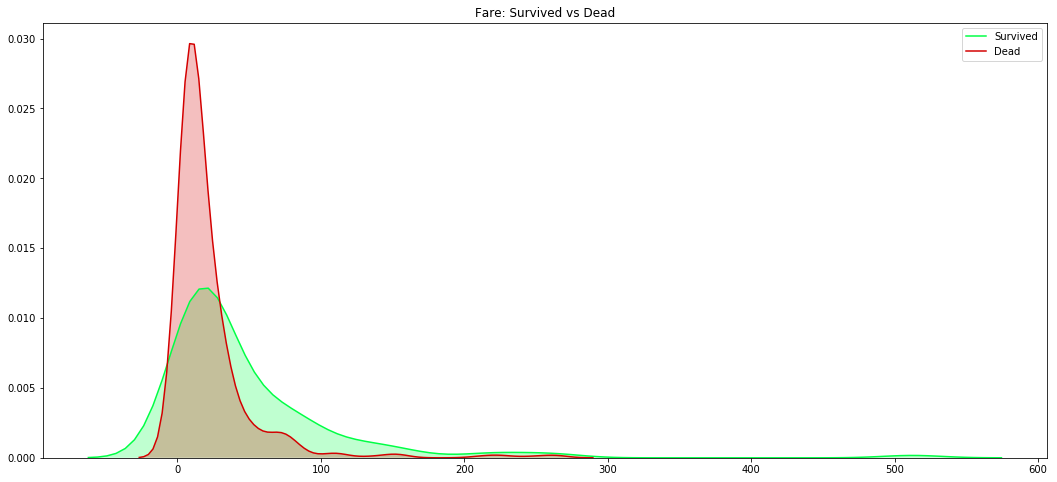

In [15]:
temp_survived_fares = pd.DataFrame()
temp_dead_fares = pd.DataFrame()
temp_dead_fare_list = []
temp_survived_fare_list = []
for i in train_data.values:
    if i[0] == 0:
        temp_dead_fare_list.append(i[6])
    if i[0] == 1:
        temp_survived_fare_list.append(i[6])
        
temp_dead_fares['Dead'] = temp_dead_fare_list          
temp_survived_fares['Survived'] = temp_survived_fare_list       

fig6, ax1 = plt.subplots(figsize=(18,8))
sns.kdeplot(temp_survived_fares['Survived'], color='#00ff45', shade=True)
sns.kdeplot(temp_dead_fares['Dead'], color='#d40000', shade=True)
ax1.set_title('Fare: Survived vs Dead')
plt.show()

Görülğü gibi bilet ücreti ile kurtulma ihtimali arasında yüksek bir bağıntı var bilet ücreti 0'a yaklaştıkça kurtulma ihtimali çok azalırken, bilet ücreti arttıkça kurtulma şansı artıyor.Buda büyük ihtimal ile güverte konumu ile ilgili yani **Pclass** ile.Böylece **Fare** yani bilet ücretini'de kullanmaya karar veriyorum.

Sıra **Cabin** özniteliğinde. Bu öznitelikte çok fazla **NaN** değer var.

In [16]:
train_data['Cabin'].isnull().sum()

687

Dolayısıyla öznitelik olarak kullanmıyorum.

In [17]:
train_data = train_data.drop('Cabin',axis = 1)
test_data = test_data.drop('Cabin',axis = 1)

Geriye son olarak **Embarked** özniteliği kaldı.Ancak aynı **Age**'de olduğu gibi bazı **nan** verilere sahip. **Embarked** bloğu veri seti içerisinde belirtildiği gibi yolcuların hangi limanda gemiye bindiğini söylüyor.Tüm veri seti içerisinde en çok **S, Southampton** olduğu için hakkında bilgi bilmediğimiz insanları da bu gruba dahil ediyoruz.

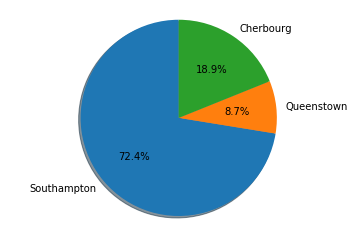

In [18]:
number_of_S = 0
number_of_Q = 0
number_of_C = 0
for i in train_data['Embarked']:
    if i == 'S':
        number_of_S = number_of_S+1
    if i == 'Q':
        number_of_Q = number_of_Q+1
    if i == 'C':
        number_of_C = number_of_C+1

labels = 'Southampton','Queenstown','Cherbourg'
sizes = [number_of_S, number_of_Q, number_of_C]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

In [19]:
train_data['Embarked'].fillna('S',inplace=True)
test_data['Embarked'].fillna('S',inplace=True)

Hangi öznitelikleri kullancağımızı seçtikten sonra bu özniteliklere bazı ayarlamalar yapmamız gerekiyor.
Mesela **Embarked** bloğunda ki **string** verilerini sayısal şekilde ifade etmeliyiz yani encode etmeliyiz.Bunu yapmamızın sebebi ağımıza vermemiz gereken özniteliklerin sayısal olarak ifade edilme zorunluluğu.

In [20]:
train_data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
test_data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)

**Sex** yani cinsiyet kısmına geçiyoruz.Cinsiyeti yine string formundan integer formuna çeviriyoruz.**Male** yani Erkekleri **0** ile Kadınları **1** ile temsil ediyoruz.

In [21]:
train_data['Sex'].replace(['male','female'],[0,1],inplace=True)
test_data['Sex'].replace(['male','female'],[0,1],inplace=True)

**Fare** sütununda bulunan **NaN** verilerini de **Age** sütununda yaptığımız gibi ortalama ile değiştiriyoruz.

In [22]:
train_data.loc[train_data.Fare.isnull(),'Fare'] = int(train_data['Fare'].mean())
test_data.loc[test_data.Fare.isnull(),'Fare'] = int(test_data['Fare'].mean())

Son olarak yapmamız gereken tüm verilerimizi -1 ile 1 arasına çekmek böylece öznitelikler arasında ki artış ya da azalışın birbirlerinden çok farklı olması önlüyoruz.

In [23]:
train_data['Pclass'] = StandardScaler().fit_transform(train_data['Pclass'].values.reshape(-1, 1))
train_data['Fare'] = StandardScaler().fit_transform(train_data['Fare'].values.reshape(-1, 1))
train_data['Age'] = StandardScaler().fit_transform(train_data['Age'].values.reshape(-1, 1))
train_data['Parch'] = StandardScaler().fit_transform(train_data['Parch'].values.reshape(-1, 1))
train_data['SibSp'] = StandardScaler().fit_transform(train_data['SibSp'].values.reshape(-1, 1))
train_data['Embarked'] = StandardScaler().fit_transform(train_data['Embarked'].values.reshape(-1, 1))
train_data['Sex'] = StandardScaler().fit_transform(train_data['Sex'].values.reshape(-1, 1))

test_data['Pclass'] = StandardScaler().fit_transform(test_data['Pclass'].values.reshape(-1, 1))
test_data['Fare'] = StandardScaler().fit_transform(test_data['Fare'].values.reshape(-1, 1))
test_data['Age'] = StandardScaler().fit_transform(test_data['Age'].values.reshape(-1, 1))
test_data['Parch'] = StandardScaler().fit_transform(test_data['Parch'].values.reshape(-1, 1))
test_data['SibSp'] = StandardScaler().fit_transform(test_data['SibSp'].values.reshape(-1, 1))
test_data['Embarked'] = StandardScaler().fit_transform(test_data['Embarked'].values.reshape(-1, 1))
test_data['Sex'] = StandardScaler().fit_transform(test_data['Sex'].values.reshape(-1, 1))

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Son durumda verilerimiz şu şekilde gözüküyor.Artık eğitim için hazırız.

In [24]:
train_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,0.827377,-0.737695,-0.581659,0.432793,-0.473674,-0.502445,-0.568837
1,1,-1.566107,1.355574,0.649327,0.432793,-0.473674,0.786845,1.005181
2,1,0.827377,1.355574,-0.273913,-0.474545,-0.473674,-0.488854,-0.568837
3,1,-1.566107,1.355574,0.418517,0.432793,-0.473674,0.420730,-0.568837
4,0,0.827377,-0.737695,0.418517,-0.474545,-0.473674,-0.486337,-0.568837
5,0,0.827377,-0.737695,-0.043103,-0.474545,-0.473674,-0.478116,2.579199
6,0,-1.566107,-0.737695,1.880313,-0.474545,-0.473674,0.395814,-0.568837
7,0,0.827377,-0.737695,-2.120392,2.247470,0.767630,-0.224083,-0.568837
8,1,0.827377,1.355574,-0.196976,-0.474545,2.008933,-0.424256,-0.568837
9,1,-0.369365,1.355574,-1.197152,0.432793,-0.473674,-0.042956,1.005181


In [25]:
test_data

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.873482,-0.755929,0.339424,-0.499470,-0.400248,-0.498380,2.243165
1,0.873482,1.322876,1.329924,0.616992,-0.400248,-0.513247,-0.677841
2,-0.315819,-0.755929,2.518523,-0.499470,-0.400248,-0.465061,2.243165
3,0.873482,-0.755929,-0.254876,-0.499470,-0.400248,-0.483439,-0.677841
4,0.873482,1.322876,-0.651076,0.616992,0.619896,-0.418445,-0.677841
5,0.873482,-0.755929,-1.284996,-0.499470,-0.400248,-0.473354,-0.677841
6,0.873482,1.322876,-0.017156,-0.499470,-0.400248,-0.501966,2.243165
7,-0.315819,-0.755929,-0.334116,0.616992,0.619896,-0.118796,-0.677841
8,0.873482,1.322876,-0.968036,-0.499470,-0.400248,-0.509138,0.782662
9,0.873482,-0.755929,-0.730316,1.733455,-0.400248,-0.205755,-0.677841


Şimdi çıktılar ve girdilerimizi ayarlayalım.**X** girdiler **Y** çıktılar olacak.Train verisinin %10'luk bir kısmını validation verisi olarak kullanacağım. Test verisiyle şimdilik bir işim yok.

In [26]:
output = train_data['Survived'].values
output = to_categorical(output, 2)

In [27]:
train_data = train_data.drop('Survived',axis = 1)

In [28]:
inputs = train_data.values

In [29]:
X_train, X_validation, y_train, y_validation = train_test_split(inputs, output, test_size=0.1)

**Sequential** Bir model kuruyoruz. 3 katmanlı olacak olan modelimiz 7 adet özniteliğe sahip olacak.

In [30]:
model = Sequential()
model.add(Dense(200, input_dim=7, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(500, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [31]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.sgd(),
              metrics=['accuracy'])

In [32]:
model.fit(X_train, y_train, 
          batch_size=200, 
          epochs=600)

Epoch 1/600
801/801 [==============================] - 0s 153us/step - loss: 0.7309 - acc: 0.5181
Epoch 2/600
801/801 [==============================] - 0s 47us/step - loss: 0.6628 - acc: 0.6317
Epoch 3/600
801/801 [==============================] - 0s 45us/step - loss: 0.6099 - acc: 0.6866
Epoch 4/600
801/801 [==============================] - 0s 45us/step - loss: 0.6006 - acc: 0.7004
Epoch 5/600
801/801 [==============================] - 0s 46us/step - loss: 0.5663 - acc: 0.7341
Epoch 6/600
801/801 [==============================] - 0s 43us/step - loss: 0.5502 - acc: 0.7366
Epoch 7/600
801/801 [==============================] - 0s 45us/step - loss: 0.5271 - acc: 0.7541
Epoch 8/600
801/801 [==============================] - 0s 44us/step - loss: 0.5450 - acc: 0.7553
Epoch 9/600
801/801 [==============================] - 0s 46us/step - loss: 0.5498 - acc: 0.7266
Epoch 10/600
801/801 [==============================] - 0s 44us/step - loss: 0.5174 - acc: 0.7603
Epoch 11/600
801/801 [======

801/801 [==============================] - 0s 47us/step - loss: 0.4745 - acc: 0.8077
Epoch 85/600
801/801 [==============================] - 0s 49us/step - loss: 0.4602 - acc: 0.7928
Epoch 86/600
801/801 [==============================] - 0s 48us/step - loss: 0.4730 - acc: 0.7853
Epoch 87/600
801/801 [==============================] - 0s 56us/step - loss: 0.4598 - acc: 0.8027
Epoch 88/600
801/801 [==============================] - 0s 51us/step - loss: 0.4690 - acc: 0.7878
Epoch 89/600
801/801 [==============================] - 0s 45us/step - loss: 0.5003 - acc: 0.7753
Epoch 90/600
801/801 [==============================] - 0s 57us/step - loss: 0.4839 - acc: 0.7865
Epoch 91/600
801/801 [==============================] - 0s 45us/step - loss: 0.4809 - acc: 0.7840
Epoch 92/600
801/801 [==============================] - 0s 47us/step - loss: 0.4788 - acc: 0.7890
Epoch 93/600
801/801 [==============================] - 0s 45us/step - loss: 0.4967 - acc: 0.7778
Epoch 94/600
801/801 [===========

801/801 [==============================] - 0s 80us/step - loss: 0.4711 - acc: 0.7965
Epoch 168/600
801/801 [==============================] - 0s 75us/step - loss: 0.4628 - acc: 0.7915
Epoch 169/600
801/801 [==============================] - 0s 61us/step - loss: 0.4682 - acc: 0.7915
Epoch 170/600
801/801 [==============================] - 0s 65us/step - loss: 0.4799 - acc: 0.8052
Epoch 171/600
801/801 [==============================] - 0s 59us/step - loss: 0.4645 - acc: 0.8065
Epoch 172/600
801/801 [==============================] - 0s 59us/step - loss: 0.4606 - acc: 0.7978
Epoch 173/600
801/801 [==============================] - 0s 74us/step - loss: 0.4637 - acc: 0.7928
Epoch 174/600
801/801 [==============================] - 0s 68us/step - loss: 0.4702 - acc: 0.8002
Epoch 175/600
801/801 [==============================] - 0s 44us/step - loss: 0.4806 - acc: 0.7953
Epoch 176/600
801/801 [==============================] - 0s 45us/step - loss: 0.4907 - acc: 0.7828
Epoch 177/600
801/801 [=

801/801 [==============================] - 0s 56us/step - loss: 0.4789 - acc: 0.7815
Epoch 250/600
801/801 [==============================] - 0s 59us/step - loss: 0.4644 - acc: 0.8065
Epoch 251/600
801/801 [==============================] - 0s 49us/step - loss: 0.4650 - acc: 0.7940
Epoch 252/600
801/801 [==============================] - 0s 47us/step - loss: 0.4713 - acc: 0.7890
Epoch 253/600
801/801 [==============================] - 0s 47us/step - loss: 0.4857 - acc: 0.7953
Epoch 254/600
801/801 [==============================] - 0s 52us/step - loss: 0.4514 - acc: 0.8102
Epoch 255/600
801/801 [==============================] - 0s 50us/step - loss: 0.4543 - acc: 0.8052
Epoch 256/600
801/801 [==============================] - 0s 50us/step - loss: 0.4661 - acc: 0.7953
Epoch 257/600
801/801 [==============================] - 0s 48us/step - loss: 0.4668 - acc: 0.7915
Epoch 258/600
801/801 [==============================] - 0s 48us/step - loss: 0.4614 - acc: 0.8002
Epoch 259/600
801/801 [=

801/801 [==============================] - 0s 51us/step - loss: 0.4784 - acc: 0.7940
Epoch 332/600
801/801 [==============================] - 0s 61us/step - loss: 0.4810 - acc: 0.7940
Epoch 333/600
801/801 [==============================] - 0s 48us/step - loss: 0.4708 - acc: 0.7878
Epoch 334/600
801/801 [==============================] - 0s 50us/step - loss: 0.4647 - acc: 0.7903
Epoch 335/600
801/801 [==============================] - 0s 45us/step - loss: 0.4826 - acc: 0.7803
Epoch 336/600
801/801 [==============================] - 0s 47us/step - loss: 0.4771 - acc: 0.7840
Epoch 337/600
801/801 [==============================] - 0s 48us/step - loss: 0.4773 - acc: 0.7790
Epoch 338/600
801/801 [==============================] - 0s 57us/step - loss: 0.4638 - acc: 0.7878
Epoch 339/600
801/801 [==============================] - 0s 48us/step - loss: 0.4617 - acc: 0.7928
Epoch 340/600
801/801 [==============================] - 0s 49us/step - loss: 0.4846 - acc: 0.7815
Epoch 341/600
801/801 [=

801/801 [==============================] - 0s 56us/step - loss: 0.4796 - acc: 0.7865
Epoch 414/600
801/801 [==============================] - 0s 50us/step - loss: 0.4712 - acc: 0.7928
Epoch 415/600
801/801 [==============================] - 0s 51us/step - loss: 0.4670 - acc: 0.7953
Epoch 416/600
801/801 [==============================] - 0s 58us/step - loss: 0.4720 - acc: 0.7865
Epoch 417/600
801/801 [==============================] - 0s 52us/step - loss: 0.4720 - acc: 0.7990
Epoch 418/600
801/801 [==============================] - 0s 58us/step - loss: 0.4898 - acc: 0.7878
Epoch 419/600
801/801 [==============================] - 0s 56us/step - loss: 0.4805 - acc: 0.7928
Epoch 420/600
801/801 [==============================] - 0s 68us/step - loss: 0.4705 - acc: 0.7740
Epoch 421/600
801/801 [==============================] - 0s 77us/step - loss: 0.4727 - acc: 0.7928
Epoch 422/600
801/801 [==============================] - 0s 53us/step - loss: 0.4635 - acc: 0.8027
Epoch 423/600
801/801 [=

801/801 [==============================] - 0s 59us/step - loss: 0.4513 - acc: 0.8077
Epoch 496/600
801/801 [==============================] - 0s 47us/step - loss: 0.4648 - acc: 0.8027
Epoch 497/600
801/801 [==============================] - 0s 47us/step - loss: 0.4605 - acc: 0.7953
Epoch 498/600
801/801 [==============================] - 0s 51us/step - loss: 0.4666 - acc: 0.7965
Epoch 499/600
801/801 [==============================] - 0s 47us/step - loss: 0.4737 - acc: 0.7890
Epoch 500/600
801/801 [==============================] - 0s 53us/step - loss: 0.4557 - acc: 0.7953
Epoch 501/600
801/801 [==============================] - 0s 46us/step - loss: 0.4672 - acc: 0.8090
Epoch 502/600
801/801 [==============================] - 0s 47us/step - loss: 0.4650 - acc: 0.7940
Epoch 503/600
801/801 [==============================] - 0s 52us/step - loss: 0.4585 - acc: 0.8027
Epoch 504/600
801/801 [==============================] - 0s 49us/step - loss: 0.4509 - acc: 0.7853
Epoch 505/600
801/801 [=

801/801 [==============================] - 0s 47us/step - loss: 0.4624 - acc: 0.7890
Epoch 578/600
801/801 [==============================] - 0s 48us/step - loss: 0.4634 - acc: 0.7928
Epoch 579/600
801/801 [==============================] - 0s 45us/step - loss: 0.4618 - acc: 0.7965
Epoch 580/600
801/801 [==============================] - 0s 48us/step - loss: 0.4615 - acc: 0.7915
Epoch 581/600
801/801 [==============================] - 0s 49us/step - loss: 0.4712 - acc: 0.7803
Epoch 582/600
801/801 [==============================] - 0s 45us/step - loss: 0.4727 - acc: 0.7890
Epoch 583/600
801/801 [==============================] - 0s 48us/step - loss: 0.4622 - acc: 0.8002
Epoch 584/600
801/801 [==============================] - 0s 46us/step - loss: 0.4692 - acc: 0.7790
Epoch 585/600
801/801 [==============================] - 0s 48us/step - loss: 0.4638 - acc: 0.7953
Epoch 586/600
801/801 [==============================] - 0s 47us/step - loss: 0.4627 - acc: 0.7928
Epoch 587/600
801/801 [=

In [33]:
acc = model.evaluate(X_validation, y_validation)
print('Hata Toplami(LOSS):', acc[0])
print('Basari(ACC):', acc[1])

90/90 [==============================] - 0s 251us/step
Hata Toplami(LOSS): 0.42028234601
Basari(ACC): 0.811111112436


%80 civarı bir başarı yakaladık şimdi test verimizi bu modele göre tahmin etme zamanı daha sonra tahminlerimizi bir dosyaya çıkartacağız.

In [34]:
 test_survived = model.predict_classes(test_data)

Tahmin işleminden sonta pandas ile liste oluşturup tahminleri ve daha önce sakladığımız test verisinin id'lerini birleştiriyoruz.

In [35]:
submission = pd.DataFrame()
submission['PassengerId'] = test_data_id_list
submission['Survived'] = test_survived

418 satır ve 2 sütundan oluşan submission dosyamız hazır.

In [36]:
submission.shape

(418, 2)

.csv dosyası olarak dışarı çıkartıyoruz

In [37]:
submission.to_csv('submission.csv', index=False)